# _STEGNOGRAPHY_
<span style="color: #e68383ff;">
the method of hiding message in image
</span>

In [1]:
from scipy.stats import chisquare

def get_detectability_score(image, pixel_coords):
    """
    Runs a Chi-Squared test on the LSBs of the given pixel coordinates.
    A lower score (p-value) is better, meaning the LSBs already look random.
    """
    if not pixel_coords:
        return 1.0  # Cannot test, so return a bad score

    img_map = image.load()
    lsb_values = []
    
    # Get the 3 LSBs (R, G, B) from every pixel in the list
    for x, y in pixel_coords:
        r, g, b = img_map[x, y][:3]
        lsb_values.append(r & 1)
        lsb_values.append(g & 1)
        lsb_values.append(b & 1)
        
    # Count occurrences of 0s and 1s
    observed_counts = np.bincount(lsb_values, minlength=2)
    
    # If all LSBs are the same (e.g., all 0), this is very detectable
    if 0 in observed_counts:
        return 1000.0 # Return a very high (bad) score
        
    # Expected counts are a 50/50 split
    expected_counts = [len(lsb_values) / 2, len(lsb_values) / 2]
    
    # Chi-Squared test
    # We care about the statistic, not the p-value.
    # A low statistic means observed is close to expected (random).
    chi_stat, p_value = chisquare(observed_counts, expected_counts)
    
    return chi_stat

In [2]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import math

# --- Add this new helper function ---
def get_pixel_list_for_color(image, message, secret_color):
    """
    A helper function that runs your logic to find *which* pixels
    would be used for a given color. It does NOT modify the image.
    """
    binary_message = ''.join(format(ord(char), '08b') for char in message) + '1111111111111110'
    required_pixels = math.ceil(len(binary_message) / 3)

    all_pixels_data = list(image.getdata())
    
    # Calculate all distances
    distances = []
    for i, p in enumerate(all_pixels_data):
        dist = calculate_color_distance(tuple(c & 0xFE for c in p[:3]), secret_color)
        distances.append((dist, i)) # Store (distance, original_index)
        
    distances.sort() # Sort by distance
    
    if required_pixels > len(distances):
        return None, None, None # Message too long

    # Find tolerance and boundary keys just like in your code
    calculated_tolerance = distances[required_pixels - 1][0] # Get distance of the Nth pixel
    
    count_less_than_tolerance = len([d for d in distances if d[0] < calculated_tolerance])
    pixels_from_boundary_to_use = required_pixels - count_less_than_tolerance
    
    # Now find the (x, y) coordinates of the pixels to be used
    pixels_to_use = []
    pixels_on_boundary_used = 0
    width, height = image.size
    
    # This is inefficient, but matches your original loop's logic
    for y in range(height):
        for x in range(width):
            if len(pixels_to_use) < required_pixels:
                pixel_color = all_pixels_data[y * width + x]
                distance = calculate_color_distance(tuple(c & 0xFE for c in pixel_color[:3]), secret_color)
                
                use_pixel = False
                if distance < calculated_tolerance:
                    use_pixel = True
                elif distance == calculated_tolerance:
                    if pixels_on_boundary_used < pixels_from_boundary_to_use:
                        use_pixel = True
                        pixels_on_boundary_used += 1

                if use_pixel:
                    pixels_to_use.append((x, y))
            else:
                break
        if len(pixels_to_use) >= required_pixels:
            break
            
    return pixels_to_use, calculated_tolerance, pixels_from_boundary_to_use

# --- The "Adversarial" Key-Finding Function ---
def find_best_color_key(image_path, message, k=16):
    print("--- ADVERSARIAL KEY SEARCH ---")
    print(f"Step 1: Clustering image into {k} candidate colors...")
    try:
        image = Image.open(image_path)
        if image.mode not in ['RGB', 'RGBA']:
            image = image.convert('RGB')
    except Exception as e:
        print(f"Error opening image: {e}")
        return None

    # 1. Get all candidate colors
    kmeans_image = image.copy()
    kmeans_image.thumbnail((150, 150))
    np_image = np.array(kmeans_image)
    pixels = np_image.reshape(-1, np_image.shape[2])
    if kmeans_image.mode == 'RGBA':
        pixels = pixels[:, :3] 

    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(pixels)
    candidate_colors = [tuple(int(c) for c in center) for center in kmeans.cluster_centers_]
    
    print(f"Step 2: Testing {k} colors against the 'adversary' (statistical test)...")
    
    best_score = float('inf')
    best_keys = None
    
    # 2. Run the "game" for each color
    for i, color in enumerate(candidate_colors):
        # 3a. Find the pixels this color would use
        pixel_list, tolerance, boundary = get_pixel_list_for_color(image, message, color)
        
        if pixel_list is None:
            continue # Message too long, skip this color

        # 3b. Run the statistical test
        score = get_detectability_score(image, pixel_list)
        print(f"  - Candidate {i}: Color {color}, Detectability Score: {score:.4f}")
        
        # 3c. Check if this is the new winner
        if score < best_score:
            best_score = score
            best_keys = (color, tolerance, boundary)
            
    if best_keys:
        print(f"\n--- Winner Found! ---")
        print(f"Best Color: {best_keys[0]} (Score: {best_score:.4f})")
        return best_keys
    else:
        print("Error: Could not find any suitable keys.")
        return None

In [3]:
# (Keep your calculate_color_distance function)
def calculate_color_distance(color1, color2):
    return np.sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(color1[:3], color2[:3])]))   

# --- Main Encoding Function ---
def encode_with_adversarial_keys(image_path, message, k_value):
    
    print("--- STARTING ENCODING ---")
    # Step 1: Run the adversarial search to get the 3 keys
    key_results = find_best_color_key(image_path, message, k=k_value)
    
    if key_results is None:
        print("Encoding failed: Could not find optimal keys.")
        return None
        
    secret_color_key, tolerance_key, boundary_key = key_results
    
    # All subsequent logic is from your original code, just using the keys we found
    try:
        image = Image.open(image_path)
        if image.mode not in ['RGB', 'RGBA']:
            image = image.convert('RGB')
            
        binary_message = ''.join(format(ord(char), '08b') for char in message) + '1111111111111110'
        required_pixels = math.ceil(len(binary_message) / 3)
        
        print("\nStep 2: Hiding the message using the winning keys...")
        message_index = 0
        pixels_used = 0
        pixels_on_boundary_used = 0
        
        img_map = image.load()
        for y in range(image.height):
            for x in range(image.width):
                if message_index < len(binary_message):
                    pixel_color = img_map[x, y]
                    pixel_for_distance_calc = tuple(c & 0xFE for c in pixel_color[:3])
                    distance = calculate_color_distance(pixel_for_distance_calc, secret_color_key)
                    
                    use_pixel = False
                    if distance < tolerance_key:
                        use_pixel = True
                    elif distance == tolerance_key:
                        if pixels_on_boundary_used < boundary_key:
                            use_pixel = True
                            pixels_on_boundary_used += 1

                    if use_pixel:
                        r, g, b = pixel_color[:3]
                        bits_to_hide = binary_message[message_index : message_index + 3]
                        
                        new_r = r & 0xFE | int(bits_to_hide[0]) if len(bits_to_hide) > 0 else r
                        new_g = g & 0xFE | int(bits_to_hide[1]) if len(bits_to_hide) > 1 else g
                        new_b = b & 0xFE | int(bits_to_hide[2]) if len(bits_to_hide) > 2 else b
                        
                        if image.mode == 'RGBA':
                            img_map[x, y] = (new_r, new_g, new_b, pixel_color[3])
                        else:
                            img_map[x, y] = (new_r, new_g, new_b)

                        message_index += len(bits_to_hide)
                        pixels_used += 1
                else:
                    break
            if message_index >= len(binary_message):
                break
        
        print(f"Message hidden within {pixels_used} pixels.")
        output_filename = f'{image_path.split(".")[0]}_encoded.png'
        image.save(output_filename)
        print(f"Encoded image saved as '{output_filename}'")
        
        # Return the 3 keys that were chosen
        return (secret_color_key, tolerance_key, boundary_key)

    except Exception as e:
        print(f"An error occurred during encoding: {e}")
        return None

In [12]:
if __name__ == '__main__':
    original_image_file = 'Examples/thor_ragnarok.jpg' 
    secret_message = """Thor: Ragnarok (2017) follows Thor as he returns to Asgard after learning of his father Odin's impending death, only to unleash his powerful sister, Hela, the Goddess of Death, who seeks to rule Asgard. Stripped of his hammer Mjolnir and banished to the distant planet Sakaar, Thor is captured by the Grandmaster and forced to fight his old ally, the Hulk, in a gladiatorial arena. With the help of Hulk, Valkyrie, and Loki, Thor escapes and returns to Asgard to stop Hela. Realizing he cannot defeat her directly, he triggers Ragnarok the prophesied destruction of Asgard to ensure her demise, escaping with his people to find a new home, embracing his destiny as the true King of Asgard.
"""
    
    # Run the encoding
    encoding_keys = encode_with_adversarial_keys(original_image_file, 
                                                 secret_message, 
                                                 SECRET_K_VALUE)
    
    if encoding_keys:
        color_key, tolerance_key, boundary_key = encoding_keys                         #KEYS
        
        print("\n--- KEYS GENERATED (CHOSEN BY ADVERSARY) ---")
        print(f"Key 1 (Color): {color_key}")
        print(f"Key 2 (Tolerance): {tolerance_key}")
        print(f"Key 3 (Boundary Count): {boundary_key}")
        
    else:
        print("\nEncoding failed. Please check the error messages.")

--- STARTING ENCODING ---
--- ADVERSARIAL KEY SEARCH ---
Step 1: Clustering image into 10 candidate colors...
Step 2: Testing 10 colors against the 'adversary' (statistical test)...
  - Candidate 0: Color (123, 97, 34), Detectability Score: 1.2142
  - Candidate 1: Color (47, 92, 108), Detectability Score: 0.3185
  - Candidate 2: Color (224, 193, 60), Detectability Score: 0.8848
  - Candidate 3: Color (39, 183, 189), Detectability Score: 0.9888
  - Candidate 4: Color (28, 34, 16), Detectability Score: 2.0289
  - Candidate 5: Color (232, 125, 21), Detectability Score: 5.7212
  - Candidate 6: Color (150, 202, 186), Detectability Score: 0.2607
  - Candidate 7: Color (67, 186, 40), Detectability Score: 0.3496
  - Candidate 8: Color (177, 43, 12), Detectability Score: 0.1040
  - Candidate 9: Color (29, 95, 10), Detectability Score: 2.6002

--- Winner Found! ---
Best Color: (177, 43, 12) (Score: 0.1040)

Step 2: Hiding the message using the winning keys...
Message hidden within 1846 pixels.
E

# Decoding 

In [13]:
def decode_with_key(image_path, key_color, key_tolerance, key_boundary_count):

    print("\n--- STARTING DECODING ---")
    print(f"Using Key Color: {key_color}, Tolerance: {key_tolerance}, Boundary Count: {key_boundary_count}")
    
    try:
        image = Image.open(image_path)
        if image.mode not in ['RGB', 'RGBA']:
             print(f"Error: Unsupported image mode '{image.mode}' for decoding.")
             return "Decoding failed due to unsupported image mode."

        binary_message = ""
        delimiter = '1111111111111110'
        pixels_on_boundary_read = 0

        print("Step 1: Scanning for valid pixels using the 3-part key...")
        for y in range(image.height):
            for x in range(image.width):
                pixel_color = image.getpixel((x, y))

                pixel_for_distance_calc = tuple(c & 0xFE for c in pixel_color[:3])
                distance = calculate_color_distance(pixel_for_distance_calc, key_color)
                
                read_pixel = False
                if distance < key_tolerance:
                    read_pixel = True
                elif distance == key_tolerance:
                    if pixels_on_boundary_read < key_boundary_count:
                        read_pixel = True
                        pixels_on_boundary_read += 1
                
                if read_pixel:
                    r, g, b = pixel_color[:3]
                    binary_message += str(r & 1)
                    binary_message += str(g & 1)
                    binary_message += str(b & 1)

                if delimiter in binary_message:
                    break
            if delimiter in binary_message:
                break
        
        delimiter_pos = binary_message.find(delimiter)
        if delimiter_pos == -1:
            return "Decoding failed. Could not find message delimiter. The key may be incorrect or the image is corrupt."
            
        binary_message = binary_message[:delimiter_pos]
        decoded_message = "".join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))
        return decoded_message

    except Exception as e:
        return f"An error occurred during decoding: {e}"



encoded_image_file = f'{original_image_file.split(".")[0]}_encoded.png'
revealed_message = decode_with_key(encoded_image_file, color_key, tolerance_key, boundary_key)
print(f"The revealed message is: '{revealed_message}'")


--- STARTING DECODING ---
Using Key Color: (177, 43, 12), Tolerance: 9.695359714832659, Boundary Count: 21
Step 1: Scanning for valid pixels using the 3-part key...
The revealed message is: 'Thor: Ragnarok (2017) follows Thor as he returns to Asgard after learning of his father Odin's impending death, only to unleash his powerful sister, Hela, the Goddess of Death, who seeks to rule Asgard. Stripped of his hammer Mjolnir and banished to the distant planet Sakaar, Thor is captured by the Grandmaster and forced to fight his old ally, the Hulk, in a gladiatorial arena. With the help of Hulk, Valkyrie, and Loki, Thor escapes and returns to Asgard to stop Hela. Realizing he cannot defeat her directly, he triggers Ragnarok the prophesied destruction of Asgard to ensure her demise, escaping with his people to find a new home, embracing his destiny as the true King of Asgard.
'


# Visualization

In [20]:
def create_visualization(original_image_path, key_color, key_tolerance, key_boundary_count):

    try:
        image = Image.open(original_image_path)
        if image.mode not in ['RGB', 'RGBA']:
            print("Visualization skipped: Unsupported image mode.")
            return

        viz_image = image.copy()
        img_map = viz_image.load()
        pixels_on_boundary_highlighted = 0
        highlight_color = (255, 0, 0) # Bright red for visibility

        for y in range(viz_image.height):
            for x in range(viz_image.width):
                pixel_color = img_map[x, y]
                
                pixel_for_distance_calc = tuple(c & 0xFE for c in pixel_color[:3])
                distance = calculate_color_distance(pixel_for_distance_calc, key_color)
                
                highlight_pixel = False
                if distance < key_tolerance:
                    highlight_pixel = True
                elif distance == key_tolerance:
                    if pixels_on_boundary_highlighted < key_boundary_count:
                        highlight_pixel = True
                        pixels_on_boundary_highlighted += 1
                
                if highlight_pixel:
                    if viz_image.mode == 'RGBA':
                        img_map[x, y] = (*highlight_color, pixel_color[3])
                    else:
                        img_map[x, y] = highlight_color
        
        output_filename = f'{original_image_path.split(".")[0]}_visualization.png'
        viz_image.save(output_filename)
        print(f"Visualization image saved as '{output_filename}'")

    except Exception as e:
        print(f"An error occurred during visualization creation: {e}")

create_visualization(original_image_file, color_key, tolerance_key, boundary_key)


Visualization image saved as '/Users/hritik/Desktop/Cryptography/Project/IIITnr_visualization.png'


In [19]:
from PIL import Image
import numpy as np
import math

# --- 1. HELPER FUNCTION (Required by your code) ---
def calculate_color_distance(color1, color2):
    """Calculates the Euclidean distance between two RGB colors."""
    # Slices [:3] to ignore alpha channel if present
    return np.sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(color1[:3], color2[:3])]))

# --- 2. YOUR VISUALIZATION FUNCTION (With Fix) ---
def create_visualization(original_image_path, key_color, key_tolerance, key_boundary_count):
    """
    Highlights the pixels in an image that match the 3 steganography keys.
    """
    try:
        image = Image.open(original_image_path)
        if image.mode not in ['RGB', 'RGBA']:
            print(f"Note: Converting image mode from '{image.mode}' to 'RGB' for visualization.")
            image = image.convert('RGB')

        viz_image = image.copy()
        img_map = viz_image.load()
        pixels_on_boundary_highlighted = 0
        highlight_color = (255, 0, 0) # Bright red for visibility
        
        # --- FIX ---
        # Define a very small number (epsilon) for float comparison
        EPSILON = 1e-9 

        for y in range(viz_image.height):
            for x in range(viz_image.width):
                pixel_color = img_map[x, y]
                
                pixel_for_distance_calc = tuple(c & 0xFE for c in pixel_color[:3])
                distance = calculate_color_distance(pixel_for_distance_calc, key_color)
                
                highlight_pixel = False
                
                # --- FIX ---
                # Check if distance is "less than" tolerance, accounting for precision
                if distance < (key_tolerance - EPSILON):
                    highlight_pixel = True
                
                # --- FIX ---
                # Check if distance is "equal to" tolerance using the epsilon
                elif abs(distance - key_tolerance) < EPSILON:
                    if pixels_on_boundary_highlighted < key_boundary_count:
                        highlight_pixel = True
                        pixels_on_boundary_highlighted += 1
                
                if highlight_pixel:
                    if viz_image.mode == 'RGBA':
                        # Preserve original alpha
                        img_map[x, y] = (*highlight_color, pixel_color[3])
                    else:
                        img_map[x, y] = highlight_color
        
        output_filename = f'{original_image_file}visualization.png'
        viz_image.save(output_filename)
        print(f"\nVisualization image saved as '{output_filename}'")
        print(f"Highlighted {pixels_on_boundary_highlighted} pixels on the boundary.")

    except FileNotFoundError:
        print(f"Error: The file '{original_image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred during visualization creation: {e}")

# --- 3. SCRIPT EXECUTION (Your preferred input method) ---
if __name__ == '__main__':

    IMAGE_TO_VISUALIZE = original_image_file
    TEST_COLOR = color_key
    TEST_TOLERANCE = tolerance_key
    TEST_BOUNDARY = boundary_key
    
    print(f"Attempting to visualize keys on: '{IMAGE_TO_VISUALIZE}'")
    print(f"  - Key Color: {TEST_COLOR}")
    print(f"  - Key Tolerance: {TEST_TOLERANCE}")
    print(f"  - Key Boundary: {TEST_BOUNDARY}")
    
    # Call the function with your chosen image and keys. 
    create_visualization(original_image_file, color_key, tolerance_key, boundary_key)

Attempting to visualize keys on: 'Social Network Movie Poster (1).jpg'
  - Key Color: (120, 175, 232)
  - Key Tolerance: 39.8622628559895
  - Key Boundary: 7

Visualization image saved as 'Social Network Movie Poster (1).jpgvisualization.png'
Highlighted 7 pixels on the boundary.


In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import random

# -------------------------------
# Helper: Check if pixel belongs to cluster
# -------------------------------
def in_cluster(pixel, color_key, tolerance):
    r1, g1, b1 = pixel
    r2, g2, b2 = color_key
    dist = np.sqrt((r1-r2)**2 + (g1-g2)**2 + (b1-b2)**2)
    return dist <= tolerance

# -------------------------------
# Helper: Deterministic traversal using boundary_key
# -------------------------------
def deterministic_order(coords, boundary_key):
    seed = int(hashlib.sha256(str(boundary_key).encode()).hexdigest(), 16) % (2**32)
    random.seed(seed)
    coords_copy = coords.copy()
    random.shuffle(coords_copy)
    return coords_copy

# -------------------------------
# Helper: Embed dummy payload into cluster pixels
# -------------------------------
def embed_payload(img_arr, cluster_pixels, payload_bits):
    h, w, _ = img_arr.shape
    new_img = img_arr.copy()

    for (x, y), bit in zip(cluster_pixels, payload_bits):
        r, g, b = new_img[y, x]

        # Example: modify LSB of blue channel only
        b = (b & 0xFE) | bit
        new_img[y, x] = [r, g, b]

    return new_img

# -------------------------------
# Main Visualization Function
# -------------------------------
def create_visualization11(original_image_file, color_key, tolerance_key, boundary_key):
    # Load image
    img = Image.open(original_image_file).convert("RGB")
    img_arr = np.array(img)
    h, w, _ = img_arr.shape

    # ------------------------------------------------
    # 1. Extract cluster pixels (coords only)
    # ------------------------------------------------
    cluster_coords = []
    for y in range(h):
        for x in range(w):
            if in_cluster(img_arr[y, x], color_key, tolerance_key):
                cluster_coords.append((x, y))

    print(f"[INFO] Cluster pixels found: {len(cluster_coords)}")

    # deterministic pixel order
    cluster_coords = deterministic_order(cluster_coords, boundary_key)

    # ------------------------------------------------
    # 2. Extract LSBs BEFORE embedding
    # ------------------------------------------------
    before_lsbs = []
    for (x, y) in cluster_coords:
        b = img_arr[y, x][2]  # blue channel
        before_lsbs.append(b & 1)

    # ------------------------------------------------
    # 3. Generate dummy payload for demonstration
    # (You can replace it with real encrypted payload bits)
    # ------------------------------------------------
    payload_size_bits = min(3000, len(cluster_coords))  # safe limit
    payload_bits = np.random.randint(0, 2, payload_size_bits).tolist()

    # ------------------------------------------------
    # 4. Create stego image and extract AFTER LSBs
    # ------------------------------------------------
    stego_img_arr = embed_payload(img_arr, cluster_coords, payload_bits)

    after_lsbs = []
    for (x, y) in cluster_coords[:payload_size_bits]:
        b = stego_img_arr[y, x][2]
        after_lsbs.append(b & 1)

    # ------------------------------------------------
    # 5. Plot histogram of LSB distribution
    # ------------------------------------------------
    plt.figure(figsize=(10, 6))
    bins = np.arange(-0.5, 2, 1)

    plt.hist(before_lsbs, bins=bins, alpha=0.6, label="Before Embedding")
    plt.hist(after_lsbs, bins=bins, alpha=0.6, label="After Embedding")

    plt.xticks([0, 1])
    plt.xlabel("LSB Value")
    plt.ylabel("Frequency")
    plt.title("LSB Distribution in Selected Cluster (Before vs After Embedding)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.savefig(f'{original_image_file.split(".")[0]}_lsb_distribution.png')
    plt.show()

[INFO] Cluster pixels found: 1886


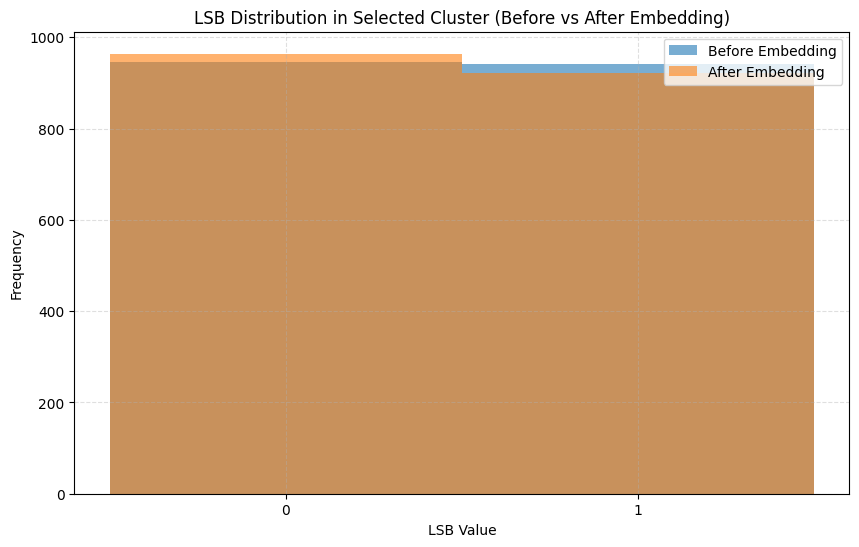

In [15]:
create_visualization11(original_image_file, color_key, tolerance_key, boundary_key)

# Test
`Test1.jpg`        **Message:** *"10 crore is hidden inside me!!"*

`oppenheimer.jpg`  **Message:** *"Now I am become Death, the destroyer of worlds."*

**Processing Details:**  
- **Key Color:** `(65, 65, 65)`  
- **Tolerance:** `1.7320508075688772`  
- **Boundary Count:** `128`

`thor_ragnarok.jpg` **Message:** *"Thor: Ragnarok (2017) follows Thor as he returns to Asgard after learning of his father Odin’s impending death, only to unleash his powerful sister, Hela, the Goddess of Death, who seeks to rule Asgard. Stripped of his hammer Mjolnir and banished to the distant planet Sakaar, Thor is captured by the Grandmaster and forced to fight his old ally, the Hulk, in a gladiatorial arena. With the help of Hulk, Valkyrie, and Loki, Thor escapes and returns to Asgard to stop Hela. Realizing he cannot defeat her directly, he triggers Ragnarok—the prophesied destruction of Asgard—to ensure her demise, escaping with his people to find a new home, embracing his destiny as the true King of Asgard."*

**Processing Details:**  
- **Key Color:** `(177, 43, 12)`  
- **Tolerance:** `9.695359714832659`  
- **Boundary Count:** `29`
- (Score: 0.0870)
- Message hidden within 1854 pixels.


